In [44]:
from veering import taut
from veering import transverse_taut
from veering import taut_carried
from veering import taut_polytope
from itertools import combinations
from itertools import permutations

In [16]:
def get_extreme_surfs(sig):
    # This function gets the branch equation form of the surfaces which span the fibered cone.
    
    extreme_rays = taut_polytope.cone_in_homology(sig) # rays (in homology) spanning the fibered cone.
    rays = taut_polytope.taut_rays(sig) # These are rays spanning the cone of carried surfaces (not sure exactly what these are tbh...)
    P = taut_polytope.projection_to_homology(sig) # This is the matrix to multiply by to get branched surface tuple to a second homology class.
    extreme_surfs = []
    for ray in rays: # this for loop stores the surfaces (in terms of their branch equations) that define the boundary of the cone
        if P*ray in extreme_rays:
            temp = 0
            for surf in extreme_surfs:
                if P*surf != P*ray:
                    temp = temp + 1
            if temp == len(extreme_surfs):
                extreme_surfs.append(ray)
            
    if [tuple(extreme_rays[0]), tuple(extreme_rays[1])] != [tuple(P*extreme_surfs[0]), tuple(P*extreme_surfs[1])]:
        extreme_surfs.reverse()
            
    return extreme_surfs

In [12]:
def get_surf_from_point_in_homology(sig, point):
    extreme_surfs = get_extreme_surfs(sig)
    P = taut_polytope.projection_to_homology(sig) # This is the matrix to multiply by to get branched surface tuple to a second homology class.
    
    eq1 = (var('r')*P*extreme_surfs[0] + var('s')*P*extreme_surfs[1])[0] == point[0]
    eq2 = (var('r')*P*extreme_surfs[0] + var('s')*P*extreme_surfs[1])[1] == point[1]
    lin_comb = solve([eq1,eq2],r,s) # find the linear combination of the boundary vectors which give our point.
    
    return lin_comb[0][0].rhs()*extreme_surfs[0] + lin_comb[0][1].rhs()*extreme_surfs[1] 

In [159]:
def num_boundary_components(sig, surface):
    # Some things in here could be less complicated if we worked with the undirected dual graph, but having the
    # full (directed) dual graph might come in handy for some things. Not sure.
    
    G = get_directed_dual_graph(sig) # load the dual graph
    tri, angle = taut.isosig_to_tri_angle(sig) 
    boundaries = taut_carried.boundary_cycles_from_surface(tri, angle, surface) # load the list of faces which in the dual graph are homotopic to the boundary components. Notice the last input is just an example surface to work with.
    temp_boundaries = boundaries[:] # temporary list that we will manipulate to keep count
    count = 0 # This will keep count of the number of boundary components
    for l in range(len(temp_boundaries)): # loop over all the boundary components of the 3-manifold
        temp_boundary = temp_boundaries[l]
        temp_boundary = [abs(ele) for ele in temp_boundary] # since we don't care about direction and we want to subtract things later, just make everything positive.
        nonzero_indices = [] # we want to make a list of every face which actually occurs in a loop homotopic to a boundary component.
        for i in range(len(temp_boundary)):
            if temp_boundary[i] != 0:
                nonzero_indices.append(i)
        
        longest_possible_cycle = len(nonzero_indices) # the longest possible cycle is the number of faces which occur, since faces can't occur twice in a loop.

        while temp_boundary != [0]*len(temp_boundary): # while there are still face entries that haven't been accounted for in loops
            for i in range(1, longest_possible_cycle + 1):
                subset = list(combinations(nonzero_indices, i)) # make lists of all possible loops consisting of i faces
                #print(subset) # for testing
                for j in range(len(subset)): # for each potential i element loop
                    edges = []
                    for face in subset[j]:
                        edges.append(get_edge_in_graph_from_face_label(G,face)) # consider the graph with the edges in this subset.
                    #print(edges) # for testing
                    subgraph = DiGraph(edges)
                    #print(subgraph.is_cycle(directed_cycle = False)) # for testing
                    if subgraph.is_cycle(directed_cycle = False): # if that subgraph forms a loop
                        if 0 not in [temp_boundary[face] for face in subset[j]]: # and temp_boundary still has nonzero entries for all the faces in that loop (so they haven't all been accounted for)
                            sub = min([temp_boundary[l] for l in subset[j]]) # subtract however many times this loops occurs from each entry in temp_boundary
                            for face in subset[j]:
                                temp_boundary[face] -= sub
                            #print(temp_boundary) # This is for testing
                            count += sub # and add another boundary component to temp.
                    
    return count

In [197]:
rays = taut_polytope.taut_rays(sig)
rays

[(0, 0, 0, 1, 2, 0, 0, 0, 1, 0),
 (1, 0, 1, 0, 0, 1, 1, 0, 0, 0),
 (1, 0, 0, 0, 0, 1, 1, 1, 0, 0),
 (2, 0, 0, 0, 1, 0, 1, 0, 0, 0),
 (0, 1, 2, 0, 3, 0, 1, 0, 0, 1),
 (0, 0, 2, 2, 5, 0, 1, 0, 0, 2),
 (0, 0, 0, 2, 5, 0, 1, 2, 0, 2),
 (0, 2, 0, 0, 5, 0, 1, 2, 2, 0),
 (0, 2, 2, 0, 5, 0, 1, 0, 2, 0),
 (0, 1, 0, 0, 3, 0, 1, 2, 0, 1),
 (0, 0, 0, 1, 0, 5, 3, 6, 0, 1),
 (0, 0, 0, 1, 0, 4, 2, 4, 1, 0),
 (0, 1, 0, 0, 0, 5, 3, 6, 1, 0),
 (0, 1, 0, 0, 0, 6, 4, 8, 0, 1),
 (0, 0, 6, 1, 0, 5, 3, 0, 0, 1),
 (0, 0, 4, 1, 0, 4, 2, 0, 1, 0),
 (0, 1, 6, 0, 0, 5, 3, 0, 1, 0),
 (0, 1, 8, 0, 0, 6, 4, 0, 0, 1)]

In [ ]:
def get_num_boundary_components(sig, point):
    return num_boundary_components(sig, get_surface_from_point_in_homology(sig, point))

In [195]:
sig = 'fLLQcbecdeepuwsua_20102'
tri, angle = taut.isosig_to_tri_angle(sig)
for i in range(len(taut_polytope.taut_rays(sig))):
    print(num_boundary_components(sig, taut_polytope.taut_rays(sig)[i]), taut_carried.boundary_cycles_from_surface(tri, angle, taut_polytope.taut_rays(sig)[i]))

6 [[1, 1, 0, 0, -1, 0, 0, 0, 2, 3], [-1, -1, 0, 0, 1, 0, 0, 0, -2, -3]]
2 [[0, 0, 0, 0, 0, 0, 0, 0, -1, -1], [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]]
2 [[0, 0, 0, 0, 0, 0, 0, 0, -1, -1], [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]]
2 [[0, 0, 0, 0, 0, 0, 0, 0, -1, -1], [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]]
6 [[1, 0, 0, -1, -1, 0, 0, 0, 2, 3], [-1, 0, 0, 1, 1, 0, 0, 0, -2, -3]]
10 [[2, 2, 0, 0, -2, 0, 0, 0, 3, 5], [-2, -2, 0, 0, 2, 0, 0, 0, -3, -5]]
10 [[2, 2, 0, 0, -2, 0, 0, 0, 3, 5], [-2, -2, 0, 0, 2, 0, 0, 0, -3, -5]]
14 [[2, 0, 0, -2, -2, 0, 0, 0, 5, 7], [-2, 0, 0, 2, 2, 0, 0, 0, -5, -7]]
14 [[2, 0, 0, -2, -2, 0, 0, 0, 5, 7], [-2, 0, 0, 2, 2, 0, 0, 0, -5, -7]]
6 [[1, 0, 0, -1, -1, 0, 0, 0, 2, 3], [-1, 0, 0, 1, 1, 0, 0, 0, -2, -3]]
2 [[1, 1, 0, 0, -1, 0, 0, 0, -1, 0], [-1, -1, 0, 0, 1, 0, 0, 0, 1, 0]]
2 [[1, 1, 0, 0, -1, 0, 0, 0, 0, 1], [-1, -1, 0, 0, 1, 0, 0, 0, 0, -1]]
2 [[1, 0, 0, -1, -1, 0, 0, 0, 0, 1], [-1, 0, 0, 1, 1, 0, 0, 0, 0, -1]]
2 [[1, 0, 0, -1, -1, 0, 0, 0, -1, 0], [-1, 0, 0, 1, 1, 0, 0, 0, 1, 0]]
2

In [41]:
def get_edge_in_graph_from_face_label(graph, label):
    for edge in graph.edges():
        if edge[2] == label:
            return edge

In [3]:
def get_directed_dual_graph(sig):
    tri, angle = taut.isosig_to_tri_angle(sig)
    G = DiGraph(loops = True, multiedges = True)
    top_bottom = transverse_taut.top_bottom_embeddings_of_faces(tri, angle)
    for face in tri.triangles():
        if face.embedding(0) in top_bottom[1]:
            G.add_edge(int(str(face.embedding(1))[0]), int(str(face.embedding(0))[0]), face.index())
        else:
            G.add_edge(int(str(face.embedding(0))[0]), int(str(face.embedding(1))[0]), face.index())
    return G

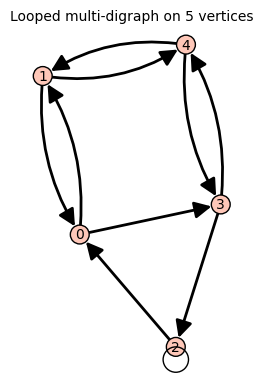

In [4]:
G = get_directed_dual_graph('fLLQcbecdeepuwsua_20102')
G

In [1]:
def get_num_boundary_components2(sig, point): # doesn't work properly right now. Close though I think.
    # Some things in here could be less complicated if we worked with the undirected dual graph, but having the
    # full (directed) dual graph might come in handy for some things. Not sure.
    
    surface = get_surf_from_point_in_homology(sig, point)
    G = get_directed_dual_graph(sig) # load the dual graph
    tri, angle = taut.isosig_to_tri_angle(sig) 
    boundaries = taut_carried.boundary_cycles_from_surface(tri, angle, surface) # load the list of faces which in the dual graph are homotopic to the boundary components. Notice the last input is just an example surface to work with.
    temp_boundaries = boundaries[:] # temporary list that we will manipulate to keep count
    count = 0 # This will keep count of the number of boundary components
    for l in range(len(temp_boundaries)): # loop over all the boundary components of the 3-manifold
        temp_boundary = temp_boundaries[l]
        temp_boundary = [abs(ele) for ele in temp_boundary] # since we don't care about direction and we want to subtract things later, just make everything positive.
        nonzero_indices = [] # we want to make a list of every face which actually occurs in a loop homotopic to a boundary component.
        for i in range(len(temp_boundary)):
            if temp_boundary[i] != 0:
                nonzero_indices.append(i)
        
        longest_possible_cycle = len(nonzero_indices) # the longest possible cycle is the number of faces which occur, since faces can't occur twice in a loop.

        while temp_boundary != [0]*len(temp_boundary): # while there are still face entries that haven't been accounted for in loops
            print(count) # for testing
            for i in range(1, longest_possible_cycle + 1):
                subset = list(combinations(nonzero_indices, i)) # make lists of all possible loops consisting of i faces
                print(subset) # for testing
                for j in range(len(subset)): # for each potential i element loop
                    edges = []
                    for face in subset[j]:
                        edges.append(get_edge_in_graph_from_face_label(G,face)) # consider the graph with the edges in this subset.
                    print(edges) # for testing
                    subgraph = DiGraph(edges)
                    print(subgraph.is_cycle(directed_cycle = False)) # for testing
                    if subgraph.is_cycle(directed_cycle = False): # if that subgraph forms a loop
                        if 0 not in [temp_boundary[face] for face in subset[j]]: # and temp_boundary still has nonzero entries for all the faces in that loop (so they haven't all been accounted for)
                            sub = min([temp_boundary[l] for l in subset[j]]) # subtract however many times this loops occurs from each entry in temp_boundary
                            for face in subset[j]:
                                temp_boundary[face] -= sub
                            print(temp_boundary) # This is for testing
                            #count += sub # This wasn't aligning with the examples from the veering code function genus_punctures.
                            count += 1 # and add another boundary component to temp.
                    
    return count

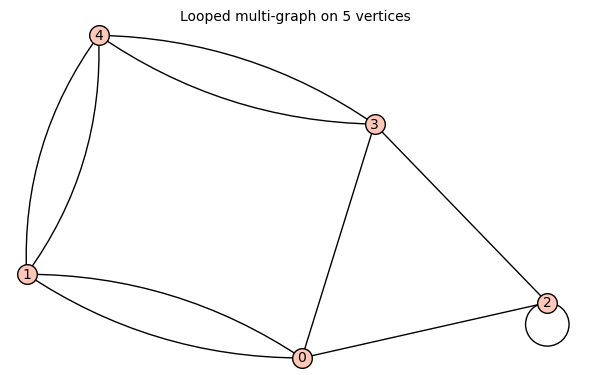

In [9]:
G = get_directed_dual_graph('fLLQcbecdeepuwsua_20102')
G
G2 = Graph(G)
G2

In [10]:
G2.edges()

[(0, 1, 1), (0, 1, 3), (0, 2, 2), (0, 3, 0), (1, 4, 4), (1, 4, 5), (2, 2, 6), (2, 3, 7), (3, 4, 8), (3, 4, 9)]

In [90]:
def get_num_punctures(sig, point):
    surface = get_surf_from_point_in_homology(sig, point)
    G = get_directed_dual_graph(sig) # load the dual graph
    tri, angle = taut.isosig_to_tri_angle(sig) 
    boundaries = taut_carried.boundary_cycles_from_surface(tri, angle, surface) # load the list of faces which in the dual graph are homotopic to the boundary components. Notice the last input is just an example surface to work with.
    print('faces traversed in the boundaries are:', boundaries)
    temp_boundaries = boundaries[:] # temporary list that we will manipulate to keep count
    count = 0 # This will keep count of the number of boundary components
    already_counted = []
    for l in range(len(temp_boundaries)): # loop over all the boundary components of the 3-manifold
        #print('already_counted:', already_counted)
        temp_boundary = temp_boundaries[l]
        temp_boundary = [abs(ele) for ele in temp_boundary] # since we don't care about direction and we want to subtract things later, just make everything positive.
        nonzero_indices = [] # we want to make a list of every face which actually occurs in a loop homotopic to a boundary component.
        for i in range(len(temp_boundary)):
            if temp_boundary[i] != 0:
                nonzero_indices.append(i)
        
        longest_possible_cycle = len(nonzero_indices) # the longest possible cycle is the number of faces which occur, since faces can't occur twice in a loop.

        while temp_boundary != [0]*len(temp_boundary): # while there are still face entries that haven't been accounted for in loops
            #print(count) # for testing
            for i in range(1, longest_possible_cycle + 1):
                print('count:', count)
                print('already counted:', already_counted)
                subset = list(combinations(nonzero_indices, i)) # make lists of all possible loops consisting of i faces
                print('length', i, 'subsets of nonzero edges:', subset) # for testing
                for j in range(len(subset)): # for each potential i element loop
                    edges = []
                    for face in subset[j]:
                        edges.append(get_edge_in_graph_from_face_label(G,face)) 
                    print('edges corresponding to', subset[j], 'are', edges) # for testing
                    subgraph = DiGraph(edges) # build the graph with the edges in this subset
                    to_check = [edge[2] for edge in edges]
                    print('to check:', to_check)
                    to_checks = list(map(list,permutations(to_check)))
                    print('to_checks:', to_checks)
                    print('is loop:', subgraph.is_cycle(directed_cycle = False)) # for testing
                    if subgraph.is_cycle(directed_cycle = False): # if that subgraph forms a loop
                        if 0 not in [temp_boundary[face] for face in subset[j]]: # and temp_boundary still has nonzero entries for all the faces in that loop (so they haven't all been accounted for)
                            sub = min([temp_boundary[l] for l in subset[j]]) # subtract however many times this loops occurs from each entry in temp_boundary
                            for face in subset[j]:
                                temp_boundary[face] -= sub
                            print(temp_boundary) # This is for testing
                            if [loop for loop in already_counted if loop in to_checks] == []: # if we haven't alreayd counted this loop
                                already_counted.append(to_check)
                                #count += sub # This wasn't aligning with the examples from the veering code function genus_punctures.
                                count += 1 # and add another boundary component to temp.
                    
    return count

In [132]:
get_num_punctures('fLLQcbecdeepuwsua_20102', (-10,10))

faces traversed in the boundaries are: [[10, 10, 0, 0, -10, 0, 0, 0, 10, 20], [-10, -10, 0, 0, 10, 0, 0, 0, -10, -20]]
count: 0
already counted: []
length 1 subsets of nonzero edges: [(0,), (1,), (4,), (8,), (9,)]
edges corresponding to (0,) are [(0, 3, 0)]
to check: [0]
to_checks: [[0]]
is loop: False
edges corresponding to (1,) are [(1, 0, 1)]
to check: [1]
to_checks: [[1]]
is loop: False
edges corresponding to (4,) are [(1, 4, 4)]
to check: [4]
to_checks: [[4]]
is loop: False
edges corresponding to (8,) are [(4, 3, 8)]
to check: [8]
to_checks: [[8]]
is loop: False
edges corresponding to (9,) are [(3, 4, 9)]
to check: [9]
to_checks: [[9]]
is loop: False
count: 0
already counted: []
length 2 subsets of nonzero edges: [(0, 1), (0, 4), (0, 8), (0, 9), (1, 4), (1, 8), (1, 9), (4, 8), (4, 9), (8, 9)]
edges corresponding to (0, 1) are [(0, 3, 0), (1, 0, 1)]
to check: [0, 1]
to_checks: [[0, 1], [1, 0]]
is loop: False
edges corresponding to (0, 4) are [(0, 3, 0), (1, 4, 4)]
to check: [0, 4]


2

In [69]:
tuple([1,2,3])


(1, 2, 3)

In [79]:
list(list(permutations([1,2,3])))

[(1, 2, 3), (1, 3, 2), (2, 1, 3), (2, 3, 1), (3, 1, 2), (3, 2, 1)]

In [135]:
def get_num_boundary_components(sig, point): # doesn't work properly right now. Close though I think.
    # Some things in here could be less complicated if we worked with the undirected dual graph, but having the
    # full (directed) dual graph might come in handy for some things. Not sure.
    
    surface = get_surf_from_point_in_homology(sig, point)
    G = get_directed_dual_graph(sig) # load the dual graph
    tri, angle = taut.isosig_to_tri_angle(sig) 
    boundaries = taut_carried.boundary_cycles_from_surface(tri, angle, surface) # load the list of faces which in the dual graph are homotopic to the boundary components.
    temp_boundaries = boundaries[:] # temporary list that we will manipulate to keep count
    count = 0 # This will keep count of the number of boundary components
    for l in range(len(temp_boundaries)): # loop over all the boundary components of the 3-manifold
        temp_boundary = temp_boundaries[l]
        temp_boundary = [abs(ele) for ele in temp_boundary] # since we don't care about direction and we want to subtract things later, just make everything positive.
        nonzero_indices = [] # we want to make a list of every face which actually occurs in a loop homotopic to a boundary component.
        for i in range(len(temp_boundary)):
            if temp_boundary[i] != 0:
                nonzero_indices.append(i)
        
        longest_possible_cycle = len(nonzero_indices) # the longest possible cycle is the number of faces which occur, since faces can't occur twice in a loop.

        while temp_boundary != [0]*len(temp_boundary): # while there are still face entries that haven't been accounted for in loops
            #print(count) # for testing
            for i in range(1, longest_possible_cycle + 1):
                subset = list(combinations(nonzero_indices, i)) # make lists of all possible loops consisting of i faces
                #print(subset) # for testing
                for j in range(len(subset)): # for each potential i element loop
                    edges = []
                    for face in subset[j]:
                        edges.append(get_edge_in_graph_from_face_label(G,face)) # consider the graph with the edges in this subset.
                    #print(edges) # for testing
                    subgraph = DiGraph(edges)
                    #print(subgraph.is_cycle(directed_cycle = False)) # for testing
                    if subgraph.is_cycle(directed_cycle = False): # if that subgraph forms a loop
                        if 0 not in [temp_boundary[face] for face in subset[j]]: # and temp_boundary still has nonzero entries for all the faces in that loop (so they haven't all been accounted for)
                            sub = min([temp_boundary[l] for l in subset[j]]) # subtract however many times this loops occurs from each entry in temp_boundary
                            for face in subset[j]:
                                temp_boundary[face] -= sub
                            #print(temp_boundary) # This is for testing
                            #count += sub # This wasn't aligning with the examples from the veering code function genus_punctures.
                            count += 1 # and add another boundary component to temp.
                    
    return count

In [134]:
def get_num_punctures(sig, point):
    # This is another attempt at the above function.
    
    surface = get_surf_from_point_in_homology(sig, point)
    G = get_directed_dual_graph(sig) # load the dual graph
    tri, angle = taut.isosig_to_tri_angle(sig) 
    boundaries = taut_carried.boundary_cycles_from_surface(tri, angle, surface) # load the list of faces which in the dual graph are homotopic to the boundary components. Notice the last input is just an example surface to work with.
    #print('faces traversed in the boundaries are:', boundaries)
    temp_boundaries = boundaries[:] # temporary list that we will manipulate to keep count
    count = 0 # This will keep count of the number of boundary components
    already_counted = []
    for l in range(len(temp_boundaries)): # loop over all the boundary components of the 3-manifold
        #print('already_counted:', already_counted)
        temp_boundary = temp_boundaries[l]
        temp_boundary = [abs(ele) for ele in temp_boundary] # since we don't care about direction and we want to subtract things later, just make everything positive.
        nonzero_indices = [] # we want to make a list of every face which actually occurs in a loop homotopic to a boundary component.
        for i in range(len(temp_boundary)):
            if temp_boundary[i] != 0:
                nonzero_indices.append(i)
        
        longest_possible_cycle = len(nonzero_indices) # the longest possible cycle is the number of faces which occur, since faces can't occur twice in a loop.

        while temp_boundary != [0]*len(temp_boundary): # while there are still face entries that haven't been accounted for in loops
            #print(count) # for testing
            for i in range(1, longest_possible_cycle + 1):
                #print('count:', count)
                #print('already counted:', already_counted)
                subset = list(combinations(nonzero_indices, i)) # make lists of all possible loops consisting of i faces
                #print('length', i, 'subsets of nonzero edges:', subset) # for testing
                for j in range(len(subset)): # for each potential i element loop
                    edges = []
                    for face in subset[j]:
                        edges.append(get_edge_in_graph_from_face_label(G,face)) 
                    #print('edges corresponding to', subset[j], 'are', edges) # for testing
                    subgraph = DiGraph(edges) # build the graph with the edges in this subset
                    to_check = [edge[2] for edge in edges]
                    #print('to check:', to_check)
                    to_checks = list(map(list,permutations(to_check)))
                    #print('to_checks:', to_checks)
                    #print('is loop:', subgraph.is_cycle(directed_cycle = False)) # for testing
                    if subgraph.is_cycle(directed_cycle = False): # if that subgraph forms a loop
                        if 0 not in [temp_boundary[face] for face in subset[j]]: # and temp_boundary still has nonzero entries for all the faces in that loop (so they haven't all been accounted for)
                            sub = min([temp_boundary[l] for l in subset[j]]) # subtract however many times this loops occurs from each entry in temp_boundary
                            for face in subset[j]:
                                temp_boundary[face] -= sub
                            #print(temp_boundary) # This is for testing
                            if [loop for loop in already_counted if loop in to_checks] == []: # if we haven't alreayd counted this loop
                                already_counted.append(to_check)
                                #count += sub # This wasn't aligning with the examples from the veering code function genus_punctures.
                                count += 1 # and add another boundary component to temp.
                    
    return count